In [1]:
import uproot
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from getS50 import getS50
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split


In [3]:
test_size = 0.4
savepath = "./fig/energy_reconstruction/"


In [ ]:
paralist_MC = [
    "nch",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "inout",
]

paralist_Expt = [
    "nch",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "S50",
]

paralist_All = {
    "nch",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "S50",
    "isgamma",
}


In [ ]:
gammafile = uproot.open("/home2/chenxu/data/gamma_all.root")
gammadata = gammafile["asresult"].arrays(paralist_MC, library="np")
gammadata["isgamma"] = np.ones_like(gammadata["nch"])
gammadata["S50"] = getS50(gammadata["ne"], gammadata["age"])
gammafile.close()


In [6]:
CRdata = dict()
for key in paralist_Expt:
    CRdata[key] = list()
# count = 0
for root, dirs, files in os.walk(
    "/home2/hky/github/Gamma_Energy/Exptdata/crabcutData_eqzenith", topdown=False
):
    for name in files:
        # print(count)
        # count += 1
        Exptdata = np.load(os.path.join(root, name))
        for key in paralist_Expt:
            CRdata[key].append(Exptdata[key])
for key in paralist_Expt:
    CRdata[key] = np.concatenate(CRdata[key])
CRdata["isgamma"]=np.zeros_like(CRdata["nch"])


In [7]:
MCcut = np.where(
    (gammadata["inout"] == 1)
    & (gammadata["S50"] >= 10**-1.2)
    & (gammadata["nch"] >= 16)
    & (gammadata["theta"] < 60)
)
Alldata = {
    key: np.concatenate([gammadata[key][MCcut], CRdata[key]]) for key in paralist_All
}
Alldata["summd_not0"] = Alldata["summd"]
Alldata["summd_not0"][Alldata["summd_not0"] == 0] = 10**-0.8


In [10]:
train_index, test_index = train_test_split(
    range(len(Alldata["nch"])), test_size=0.4, random_state=42
)
Alldata_df = pd.DataFrame(Alldata)

In [14]:
Alldata_df.loc[train_index]

,sumpf,age,cy,isgamma,mr1,ne,S50,sigma,phi,cx,summd,theta,nch,summd_not0
58352583,121.586863,0.921228,41.646574,0,42.185146,14306.660307,0.272099,0.910075,94.386069,-72.675719,31.845907,29.098030,28,31.845907
144173996,360.459649,1.252286,43.033164,0,40.422781,32650.843701,0.614125,0.507470,119.542522,-31.140384,60.191680,17.017639,71,60.191680
26266753,243.183911,0.332735,53.859084,0,34.359043,41211.822661,0.278350,0.401052,83.644479,21.633877,16.560548,55.505210,33,16.560548
114906232,88.822516,0.404974,20.045256,0,34.010905,9682.527799,0.082784,0.236833,164.442064,-36.652423,12.343722,10.090339,17,12.343722
121993180,66.071903,1.141976,32.353094,0,39.289388,5832.926080,0.114613,0.560997,106.659843,49.428682,4.405700,20.293437,17,4.405700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155299516,162.521400,0.390105,14.125484,0,31.010370,20204.614352,0.165203,0.372607,133.676372,-23.462019,27.254113,14.982927,30,27.254113
127521863,187.078381,1.075315,-15.859710,0,36.733404,12640.202465,0.250100,0.376986,-99.614598,-1.540922,4.810360,24.040426,37,4.810360
191100010,152.430329,1.116830,56.788249,0,44.783721,10529.565434,0.207794,0.485580,-143.797219,33.634630,17.477326,13.184956,24,17.477326
56755036,327.687204,0.858143,12.070353,0,41.366748,27912.090774,0.510560,0.311446,-90.219266,-32.521724,81.911026,36.986504,35,81.911026


In [15]:
Alldata_df.loc[train_index].to_csv("/home2/hky/github/Gamma_Energy/AllSky_withCR/Data/train_data.csv",index=False)
Alldata_df.loc[test_index].to_csv("/home2/hky/github/Gamma_Energy/AllSky_withCR/Data/test_data.csv",index=False)

In [16]:
g = sns.JointGrid()

sns.histplot(
    data=Alldata_df[Alldata_df["isgamma"]==0],
    x="sumpf",
    y="summd_not0",
    bins=[np.logspace(0.5, 5, 46), np.logspace(-1, 4, 51)],
    ax=g.ax_joint,
    hue="isgamma",
    # cbar=True,
)
sns.histplot(
    data=Alldata_df[Alldata_df["isgamma"]==0],
    x="sumpf",
    bins=np.logspace(0.5, 5, 46),
    ax=g.ax_marg_x,
    hue="isgamma",
    legend=False,
    # discrete=True,
)
sns.histplot(
    data=Alldata_df[Alldata_df["isgamma"]==0],
    y="summd_not0",
    bins=np.logspace(-1, 4, 51),
    ax=g.ax_marg_y,
    hue="isgamma",
    legend=False,
    # discrete=True,
)
g.ax_joint.set_xscale("log")
g.ax_joint.set_yscale("log")
# g.ax_marg_x.set_yscale("log")
# g.ax_marg_y.set_xscale("log")
# _ = g.ax_marg_x.hist(Alldata_df['sumpf'], color='#c72e29', bins=10)
# _ = g.ax_marg_y.hist(Alldata_df['summd_not0'], color='#c72e29', bins=20, orientation='horizontal')
plt.show()


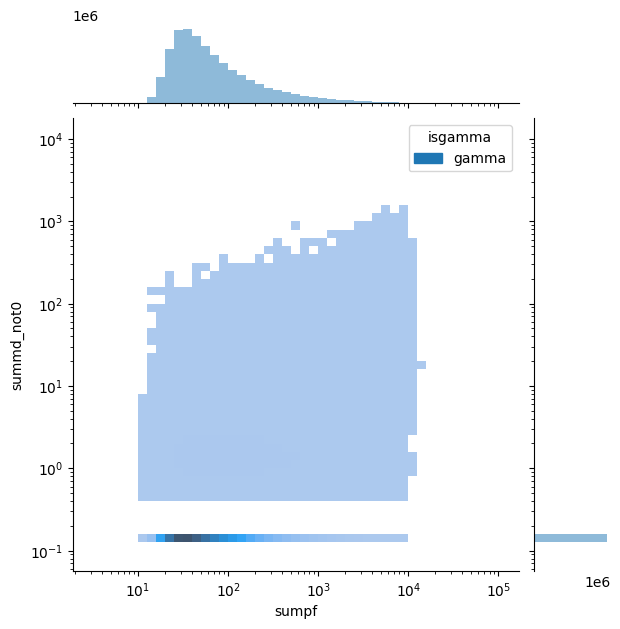

In [ ]:
g = sns.JointGrid()

sns.histplot(
    data=Alldata_df[Alldata_df["isgamma"]==1],
    x="sumpf",
    y="summd_not0",
    bins=[np.logspace(0.5, 5, 46), np.logspace(-1, 4, 51)],
    ax=g.ax_joint,
    hue="isgamma",
    # cbar=True,
)
sns.histplot(
    data=Alldata_df[Alldata_df["isgamma"]==1],
    x="sumpf",
    bins=np.logspace(0.5, 5, 46),
    ax=g.ax_marg_x,
    hue="isgamma",
    legend=False,
    # discrete=True,
)
sns.histplot(
    data=Alldata_df[Alldata_df["isgamma"]==1],
    y="summd_not0",
    bins=np.logspace(-1, 4, 51),
    ax=g.ax_marg_y,
    hue="isgamma",
    legend=False,
    # discrete=True,
)
g.ax_joint.set_xscale("log")
g.ax_joint.set_yscale("log")
# g.ax_marg_x.set_yscale("log")
# g.ax_marg_y.set_xscale("log")
# _ = g.ax_marg_x.hist(Alldata_df['sumpf'], color='#c72e29', bins=10)
# _ = g.ax_marg_y.hist(Alldata_df['summd_not0'], color='#c72e29', bins=20, orientation='horizontal')
plt.show()


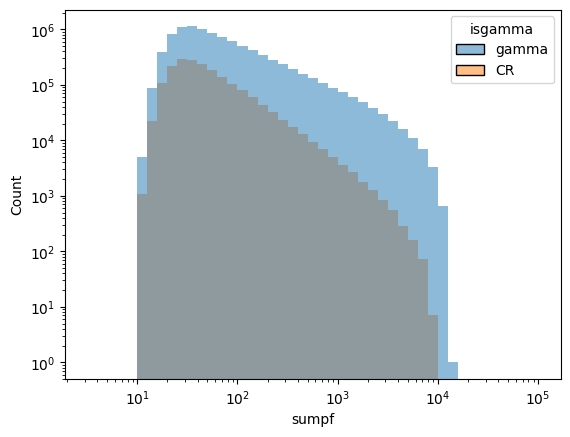

In [ ]:
sns.histplot(
    data=Alldata_df,
    x="sumpf",
    bins=np.logspace(0.5, 5, 46),
    hue="isgamma",
    # legend=False,
    # discrete=True,
)
plt.xscale("log")
plt.yscale("log")
plt.show()